In [120]:
# !pip install pandas_datareader
# !conda install -y -c conda-forge fbprophet
import boto3
import base64
from botocore.exceptions import ClientError
from IPython.display import display
import pandas_datareader
from fbprophet import Prophet
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import normalize

In [101]:
tickers = ['AAPL']
metric = 'low'
pc_metric = f'{metric}_percent_change'
norm_metric = f'{pc_metric}_norm'
def get_secret():
    secret_name = "alpha_vantage"
    region_name = "us-east-2"
    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    try:
        get_secret_value_response = client.get_secret_value(SecretId=secret_name)
    except ClientError as e:
        display(e)
    else:
        # Decrypts secret using the associated KMS CMK.
        # Depending on whether the secret is a string or binary, one of these fields will be populated.
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
        else:
            secret = base64.b64decode(get_secret_value_response['SecretBinary'])
    return secret   
def format_dates(daily_stocks_data):
    df = daily_stocks_data.copy() 
    df['date']=df.index
    df.reset_index(inplace=True, drop=True)
    return df
def add_percent_change(daily_stocks_data, metric):
    percents = list()
    for index, row in daily_stocks_data.iterrows():
        old = row[metric]
        try:
            new = daily_stocks_data.iloc[index + 1][metric]
        except Exception as e:
            percents.append(np.nan) ## no next value, so this is undefined
            continue
        percents.append((new-old)/new)
    cp_df = daily_stocks_data.copy()
    cp_df[f'{metric}_percent_change']=percents
    return cp_df
def add_norm(df, label):
    arr = np.array([x*1000 for x in df[label].to_numpy()]).reshape(-1, 1)
#     norm = normalize(arr, norm='l1')
    norm = arr
    new_df = df.copy()
    new_df[f'{label}_norm'] = norm
    return new_df

In [102]:
ALPHA_API_KEY = get_secret()

In [103]:
# daily_stocks_data_raw = pandas_datareader.av.time_series.AVTimeSeriesReader(symbols=tickers, api_key=ALPHA_API_KEY, function='TIME_SERIES_DAILY').read()
daily_stocks_data = format_dates(daily_stocks_data_raw) 
daily_stocks_data = add_percent_change(daily_stocks_data, metric)
daily_stocks_data[daily_stocks_data[pc_metric].isnull()] = 0
daily_stocks_data = add_norm(daily_stocks_data, pc_metric)
display(daily_stocks_data)

,open,high,low,close,volume,date,low_percent_change,low_percent_change_norm
0,19.75,20.62,19.50,20.560,6357300,2001-03-19,0.009650,9.649568
1,20.72,20.94,19.69,19.690,8914400,2001-03-20,-0.016520,-16.520392
2,19.78,20.87,19.37,20.120,6631700,2001-03-21,0.040614,40.614165
3,20.37,21.75,20.19,21.620,12916100,2001-03-22,0.082273,82.272727
4,22.06,23.56,22.00,23.000,16873000,2001-03-23,-0.041174,-41.173687
...,...,...,...,...,...,...,...,...
5023,120.93,121.00,116.21,116.360,154376610,2021-03-08,0.021719,21.719000
5024,119.03,122.06,118.79,121.085,129525780,2021-03-09,0.005525,5.525324
5025,121.69,122.17,119.45,119.980,111943326,2021-03-10,0.014927,14.926604
5026,122.54,123.21,121.26,121.960,103026514,2021-03-11,-0.017623,-17.623364


In [105]:
# daily_stocks_data.isin([-1, 1, 0]).all()

In [107]:
prophet_df = pd.DataFrame({'ds':daily_stocks_data['date'].to_numpy(), 'y':daily_stocks_data[norm_metric].to_numpy()})
display(prophet_df)
prophet_df_train, prophet_df_test = train_test_split(prophet_df)
display(prophet_df_train, prophet_df_test)

,ds,y
0,2001-03-19,9.649568
1,2001-03-20,-16.520392
2,2001-03-21,40.614165
3,2001-03-22,82.272727
4,2001-03-23,-41.173687
...,...,...
5023,2021-03-08,21.719000
5024,2021-03-09,5.525324
5025,2021-03-10,14.926604
5026,2021-03-11,-17.623364


,ds,y
1214,2006-01-18,-39.497079
2771,2012-03-23,1.443067
2346,2010-07-19,1.708262
3246,2014-02-13,12.952458
3791,2016-04-14,-14.581245
...,...,...
39,2001-05-14,12.586806
2485,2011-02-03,14.439172
3745,2016-02-08,9.475141
3502,2015-02-20,12.417091


,ds,y
2216,2010-01-11,-9.834318
2624,2011-08-23,36.697248
2569,2011-06-06,-17.806568
1658,2007-10-23,-19.638474
2704,2011-12-15,3.319546
...,...,...
1522,2007-04-11,-17.746914
207,2002-01-17,4.098361
3817,2016-05-20,12.020487
4599,2019-07-01,3.526023


In [108]:
model=Prophet(interval_width=0.95, daily_seasonality=True)

In [109]:
model.fit(prophet_df_train)

In [110]:
train_pred = model.make_future_dataframe(periods=100)
display(train_pred)

,ds
0,1970-01-01
1,2001-03-19
2,2001-03-22
3,2001-03-23
4,2001-03-26
...,...
3866,2021-06-13
3867,2021-06-14
3868,2021-06-15
3869,2021-06-16


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-01,0.789038,-204.057026,230.239799,0.789038,0.789038,9.695743,9.695743,9.695743,3.156159,...,1.237227,1.237227,1.237227,5.302358,5.302358,5.302358,0.0,0.0,0.0,10.484781
1,2001-03-19,-2.462680,-199.762220,233.206678,-2.462680,-2.462680,11.194565,11.194565,11.194565,3.156159,...,3.493009,3.493009,3.493009,4.545397,4.545397,4.545397,0.0,0.0,0.0,8.731885
2,2001-03-22,-2.463535,-219.393824,224.779336,-2.463535,-2.463535,8.895914,8.895914,8.895914,3.156159,...,1.237227,1.237227,1.237227,4.502528,4.502528,4.502528,0.0,0.0,0.0,6.432378
3,2001-03-23,-2.463821,-221.908657,208.015495,-2.463821,-2.463821,-2.727194,-2.727194,-2.727194,3.156159,...,-10.313871,-10.313871,-10.313871,4.430519,4.430519,4.430519,0.0,0.0,0.0,-5.191014
4,2001-03-26,-2.464676,-206.475160,239.340840,-2.464676,-2.464676,10.779839,10.779839,10.779839,3.156159,...,3.493009,3.493009,3.493009,4.130671,4.130671,4.130671,0.0,0.0,0.0,8.315163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866,2021-06-13,-6.901659,-246.704489,193.898382,-6.910276,-6.894603,-22.338728,-22.338728,-22.338728,3.156159,...,-0.394520,-0.394520,-0.394520,-25.100367,-25.100367,-25.100367,0.0,0.0,0.0,-29.240387
3867,2021-06-14,-6.901646,-254.868654,190.786253,-6.910734,-6.894448,-15.967838,-15.967838,-15.967838,3.156159,...,3.493009,3.493009,3.493009,-22.617006,-22.617006,-22.617006,0.0,0.0,0.0,-22.869484
3868,2021-06-15,-6.901632,-252.682094,183.242887,-6.911192,-6.894293,-13.704045,-13.704045,-13.704045,3.156159,...,3.061570,3.061570,3.061570,-19.921774,-19.921774,-19.921774,0.0,0.0,0.0,-20.605678
3869,2021-06-16,-6.901619,-220.703901,207.941469,-6.911644,-6.894138,-10.594110,-10.594110,-10.594110,3.156159,...,3.311105,3.311105,3.311105,-17.061374,-17.061374,-17.061374,0.0,0.0,0.0,-17.495729


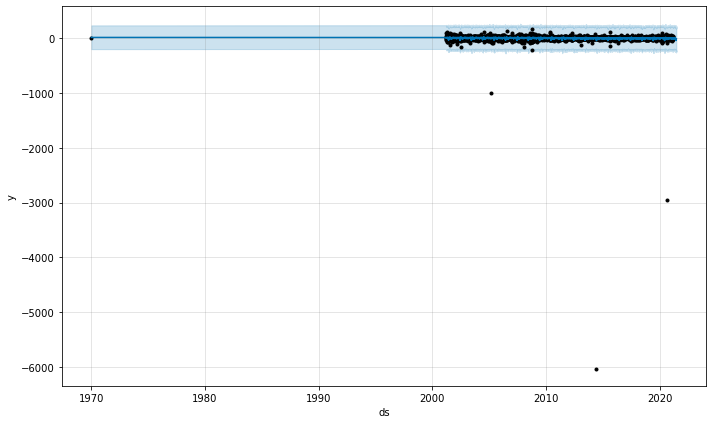

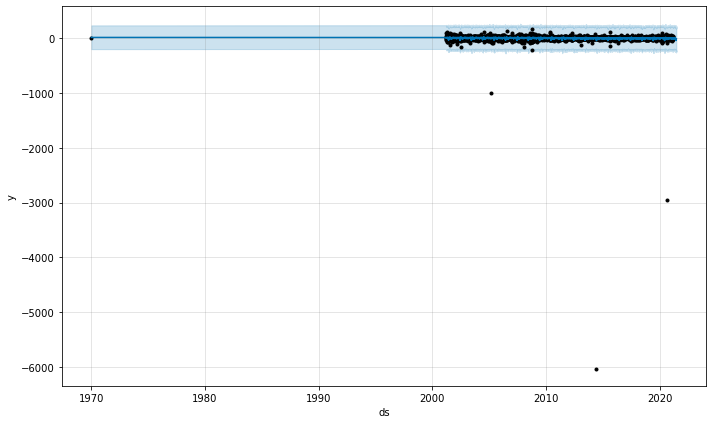

In [111]:
forecast = model.predict(train_pred)
display(forecast)
model.plot(forecast)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-03-20,-2.462965,-208.822215,231.652259,-2.462965,-2.462965,10.784203,10.784203,10.784203,3.156159,...,3.061570,3.061570,3.061570,4.566474,4.566474,4.566474,0.0,0.0,0.0,8.321238
1,2001-03-21,-2.463250,-222.179371,226.587559,-2.463250,-2.463250,11.017310,11.017310,11.017310,3.156159,...,3.311105,3.311105,3.311105,4.550046,4.550046,4.550046,0.0,0.0,0.0,8.554060
2,2001-03-28,-2.465247,-225.654848,223.037375,-2.465247,-2.465247,10.381563,10.381563,10.381563,3.156159,...,3.311105,3.311105,3.311105,3.914299,3.914299,3.914299,0.0,0.0,0.0,7.916316
3,2001-04-03,-2.466958,-202.195743,229.749347,-2.466958,-2.466958,9.630436,9.630436,9.630436,3.156159,...,3.061570,3.061570,3.061570,3.412707,3.412707,3.412707,0.0,0.0,0.0,7.163478
4,2001-04-09,-2.468670,-221.249425,228.233687,-2.468670,-2.468670,9.576753,9.576753,9.576753,3.156159,...,3.493009,3.493009,3.493009,2.927584,2.927584,2.927584,0.0,0.0,0.0,7.108083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2021-02-22,-6.903156,-230.289984,213.984882,-6.903156,-6.903156,2.936723,2.936723,2.936723,3.156159,...,3.493009,3.493009,3.493009,-3.712445,-3.712445,-3.712445,0.0,0.0,0.0,-3.966433
1253,2021-03-04,-6.903021,-213.357935,211.015336,-6.903021,-6.903021,2.997272,2.997272,2.997272,3.156159,...,1.237227,1.237227,1.237227,-1.396113,-1.396113,-1.396113,0.0,0.0,0.0,-3.905749
1254,2021-03-05,-6.903008,-239.532121,199.536710,-6.903008,-6.903008,-7.980079,-7.980079,-7.980079,3.156159,...,-10.313871,-10.313871,-10.313871,-0.822367,-0.822367,-0.822367,0.0,0.0,0.0,-14.883087
1255,2021-03-10,-6.902940,-225.429802,233.464007,-6.902940,-6.902940,8.502018,8.502018,8.502018,3.156159,...,3.311105,3.311105,3.311105,2.034754,2.034754,2.034754,0.0,0.0,0.0,1.599078


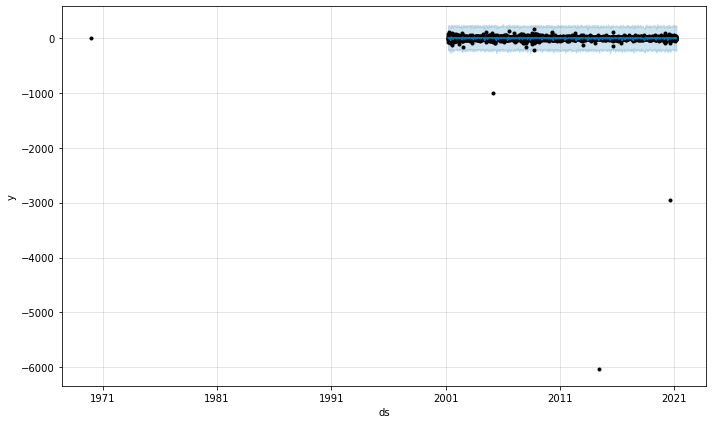

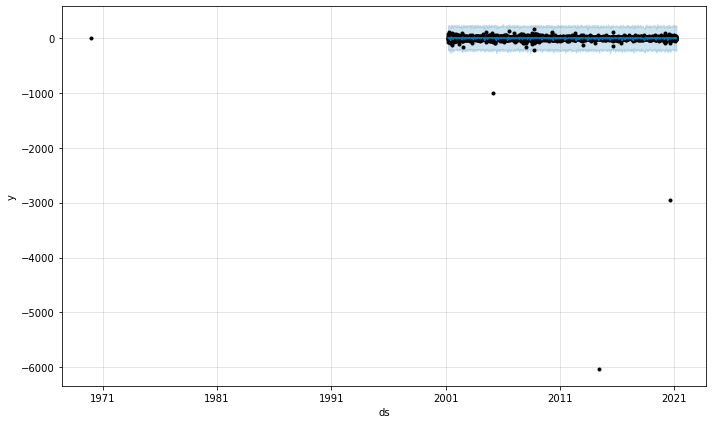

In [112]:
test_forecast = model.predict(prophet_df_test)
display(test_forecast)
model.plot(test_forecast)

In [132]:
display('predictions MAE', MAE(test_forecast['yhat'], prophet_df_test['y']))
display('MSE',MSE(test_forecast['yhat'], prophet_df_test['y']))
display('baseline MAE',MAE([0]*len(prophet_df_test['y']), prophet_df_test['y']))
display('MSE',MSE([0]*len(prophet_df_test['y']), prophet_df_test['y']))
display('mean baseline MAE',MAE([prophet_df_test['y'].mean()]*len(prophet_df_test['y']), prophet_df_test['y']))
display('MSE',MSE([prophet_df_test['y'].mean()]*len(prophet_df_test['y']), prophet_df_test['y']))
display('mean', test_forecast['yhat'].mean())
display('std', test_forecast['yhat'].std())
display('mean', prophet_df_test['y'].mean())
display('std', prophet_df_test['y'].std())

'predictions MAE'

17.314460912372294

'MSE'

625.2027949539852

'baseline MAE'

14.829804423080088

'MSE'

501.39298745819536

'mean baseline MAE'

14.743312155179515

'MSE'

501.01275150924636

'mean'

-1.660251852496811

'std'

10.132437808205877

'mean'

0.6166327504674634

'std'

22.392222913593052

In [ ]:
## worse than no change prediction or mean prediction on percentage change metric; next method. 